In [1]:
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from data_loading import process_text_df, NewsText
from utils import generate_val_set, collate_fn
from tqdm import tqdm
from models import NewsNet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import tensor

[Text(0, 0, 'False'), Text(0, 0, 'True')]

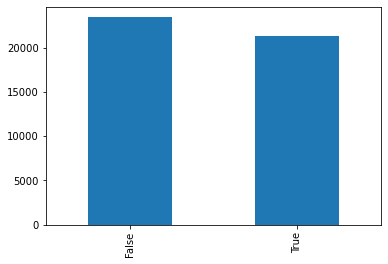

In [2]:
fake, true = pd.read_csv('data/Fake.csv'), pd.read_csv('data/True.csv')
fake['label'] = 'fake'
true['label'] = 'true'
news = pd.concat((fake, true))
news = news.sample(frac=1)
news.reset_index(inplace=True, drop=True)
ax = news.label.apply(lambda l: 1 if l =='true' else 0).value_counts().plot(kind='bar')
ax.set_xticklabels(['False', 'True'])

In [3]:
p1 = process_text_df(news, ['title', 'text'])

In [4]:
%%time
p1.process_text_col()

CPU times: user 2.82 s, sys: 1.23 s, total: 4.05 s
Wall time: 4min 28s


In [5]:
p1.df

,title,text,subject,date,label
0,"[best, reason, trump, qualifi, presidenti, can...","[obama, trump, check, media, trump, check, est...",politics,"May 18, 2016",fake
1,"[i, dont, think, standard, report, call, claim...","[think, standard, tim, carney, new, york, time...",politics,"Dec 15, 2017",fake
2,"[hollywood, actress, lena, dunham, havent, abo...","[abort, wish, lena, dunhamactress, lena, dunha...",left-news,"Dec 20, 2016",fake
3,"[flashback, key, democrat, call, violenc, stre...","[wonder, violenc, like, today, shoot, happen, ...",left-news,"Jun 14, 2017",fake
4,"[senior, democrat, nation, committe, offici, r...","[new, yorkwashington, reuter, , three, senior,...",politicsNews,"August 2, 2016",true
...,...,...,...,...,...
44893,"[reopen, feud, quota, host, refuge]","[brussel, reuter, , rival, two, side, european...",worldnews,"December 13, 2017",true
44894,"[arizona, republican, vote, airplan, seat, com...","[pure, gold, perfect, demonstr, republican, gi...",News,"April 8, 2016",fake
44895,"[hot, air, us, gas, export, rush, sell, lng, c...","[beij, reuter, , us, gas, export, trader, aim,...",worldnews,"October 27, 2017",true
44896,"[isi, march, belgium, burn, obama, hang, new, ...","[parti, barri, expect, see, behavior, first, c...",left-news,"Mar 23, 2016",fake


In [6]:
p1.tokenize_sentences()
p1.df

,title,text,subject,date,label
0,"[7354, 7353, 7352, 7351, 7350, 7349, 7348, 7347]","[7339, 7352, 7035, 7141, 7352, 7035, 5978, 732...",politics,"May 18, 2016",fake
1,"[7346, 7345, 7344, 7343, 7342, 7341, 7340, 733...","[7344, 7343, 6976, 0, 7275, 6131, 5953, 7342, ...",politics,"Dec 15, 2017",fake
2,"[7333, 7332, 0, 7331, 7330, 7329, 7328, 7327]","[7329, 7328, 0, 0, 0, 7331, 7060, 6963, 7329, ...",left-news,"Dec 20, 2016",fake
3,"[7326, 7325, 7324, 7341, 7323, 0, 7322, 7321, ...","[2286, 7323, 6775, 4836, 7065, 6967, 5815, 664...",left-news,"Jun 14, 2017",fake
4,"[7320, 7324, 7319, 7318, 7317, 7316, 7315]","[7275, 0, 5473, 7290, 5681, 7320, 7317, 7324, ...",politicsNews,"August 2, 2016",true
...,...,...,...,...,...
44893,"[6436, 5589, 4543, 6802, 7104]","[4538, 5473, 7290, 5201, 6991, 5737, 6070, 486...",worldnews,"December 13, 2017",true
44894,"[4375, 6827, 7158, 1827, 4442, 4738, 6116, 391...","[3104, 4898, 7208, 4079, 6827, 7089, 4522, 703...",News,"April 8, 2016",fake
44895,"[5486, 6808, 7283, 7212, 2337, 7295, 5627, 0, ...","[3238, 5473, 7290, 7283, 7212, 2337, 1279, 510...",worldnews,"October 27, 2017",true
44896,"[6588, 6052, 3966, 6029, 7339, 3891, 7275, 0, ...","[7259, 4900, 6396, 7150, 4953, 7145, 5826, 431...",left-news,"Mar 23, 2016",fake


In [7]:
l, labs = p1.tensorize_sentences('text', 'label', n_feature_tokens=50)

In [8]:
idx = len(l) // 4
l_tr, labs_tr = l[:2 * idx], labs[:2 * idx]
l_val, labs_val = l[2 * idx:3 * idx], labs[2 * idx:3 * idx]
l_tst, labs_tst = l[-idx:], labs[-idx:]
tr_set = NewsText(l_tr, labs_tr)
loader = DataLoader(tr_set, batch_size=8, collate_fn=collate_fn)

val_set = NewsText(l_val, labs_val)
val_set = generate_val_set(val_set)
val_features, val_labels, val_lens = val_set
val_labels = val_labels.unsqueeze(-1).float()

net = NewsNet(p1.vocab, hidden_size=4, embedding_dim=8, num_layers=2)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(net.parameters(), lr=1e-4, weight_decay=5e-6)
loss_list = []
val_loss_list = []
accuracy_list = []
epochs = 50
pbar = tqdm(total=epochs)
for i in range(epochs):
    pbar.update()
    for sents, labels, lens in loader:
        net.train()
        labels = labels.float().unsqueeze(-1)
        out = net(sents, lens)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        net.eval()
    with torch.no_grad():
        val_out = net(val_features, val_lens)
        val_loss = loss_fn(val_out, val_labels)
        val_loss_list.append(val_loss.item())
        val_guesses = torch.round(nn.Sigmoid()(val_out))
        accuracy = (val_guesses == val_labels).float().mean().item()
        
        accuracy_list.append(accuracy)
    pbar.set_description(desc=f'Completed {i + 1} out of {epochs}')
    loss_list.append(loss.item())

Completed 50 out of 50: 100%|██████████| 50/50 [38:59<00:00, 46.79s/it]

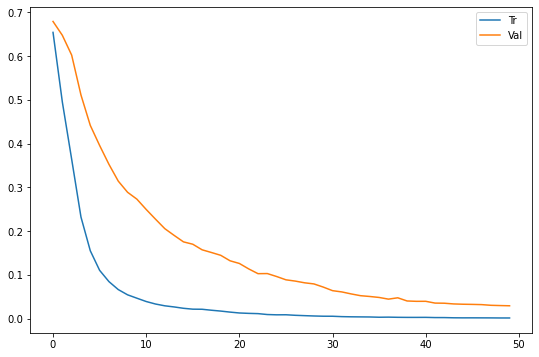

In [9]:
fig, ax = plt.subplots()
pd.Series(loss_list).plot(ax=ax, label='Tr')
pd.Series(val_loss_list).plot(ax=ax, label='Val')
fig.set_size_inches(fig.get_size_inches() * 1.5)
ax.legend()

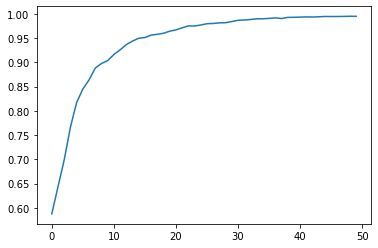

In [10]:
pd.Series(accuracy_list).plot()

In [11]:
tst_set = NewsText(l_tst, labs_tst)
tst_set = generate_val_set(tst_set)
tst_features, tst_labels, tst_lens = tst_set
tst_labels = tst_labels.unsqueeze(-1).float()

In [12]:
with torch.no_grad():
    tst_out = net(tst_features, tst_lens)
    tst_loss = loss_fn(tst_out, tst_labels)
    tst_guesses = torch.round(nn.Sigmoid()(tst_out))
    accuracy_tst = (tst_guesses == tst_labels).float().mean().item()

In [13]:
accuracy_tst

0.9936743378639221